# LSTM for predicting time series forex data


In [31]:
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import json
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time

In [32]:
# Load the candles from the json file
with open('candles.json') as data_file:    
    body = json.load(data_file)
    
candles = body['candles']    

ts = np.array(list(object['time'] for object in candles))
close = np.array(list(object['mid']['c'] for object in candles))

print("Number of candles: " + str(len(candles)))

print(candles)

Number of candles: 3000
[{'complete': True, 'time': '1489653910.000000000', 'volume': 6, 'mid': {'o': '1.07094', 'h': '1.07094', 'l': '1.07086', 'c': '1.07087'}}, {'complete': True, 'time': '1489653915.000000000', 'volume': 4, 'mid': {'o': '1.07088', 'h': '1.07099', 'l': '1.07088', 'c': '1.07099'}}, {'complete': True, 'time': '1489653920.000000000', 'volume': 2, 'mid': {'o': '1.07097', 'h': '1.07097', 'l': '1.07095', 'c': '1.07095'}}, {'complete': True, 'time': '1489653925.000000000', 'volume': 3, 'mid': {'o': '1.07098', 'h': '1.07098', 'l': '1.07093', 'c': '1.07096'}}, {'complete': True, 'time': '1489653935.000000000', 'volume': 2, 'mid': {'o': '1.07090', 'h': '1.07091', 'l': '1.07090', 'c': '1.07091'}}, {'complete': True, 'time': '1489653940.000000000', 'volume': 11, 'mid': {'o': '1.07090', 'h': '1.07093', 'l': '1.07087', 'c': '1.07088'}}, {'complete': True, 'time': '1489653945.000000000', 'volume': 8, 'mid': {'o': '1.07090', 'h': '1.07097', 'l': '1.07090', 'c': '1.07097'}}, {'comple

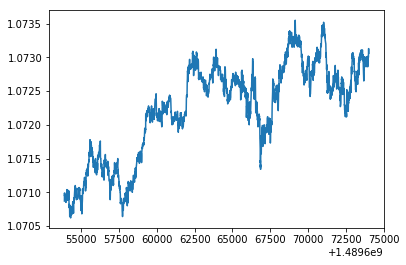

In [33]:
# Make a graph of the candles

plt.plot(ts,close)
plt.show()

In [34]:
# This function loads our candles and normalizes them

def load_data(candles, key, seq_len, normalise_window):
    close_prices = np.array(list(object['mid'][key] for object in candles)) # Strip out close prices
    data = [float(x) for x in close] # Convert to float

    sequence_length = seq_len + 1
    result = []
    
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [35]:
X_train, y_train, X_test, y_test = load_data(candles, 'c', 50, True)

print("Total X data points (train+test): " + str(len(X_train) + len(X_test)))
print("Total Y data points (train+test): " +str(len(y_train) + len(y_test)))

Total X data points (train+test): 2949
Total Y data points (train+test): 2949


In [36]:
# Use the LSTM sequential model
model = Sequential()

# Input
model.add(LSTM(input_shape=(50,1), return_sequences=True, units=50))
model.add(Dropout(0.2))

# Hidden
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
          
# Output          
model.add(Dense(units=1))
model.add(Activation('linear'))

# Compile model
start = time.time()
model.compile(loss='mse', optimizer='rmsprop')

print("Compilation time:", time.time() - start)

Compilation time: 0.04566502571105957


In [37]:
# Train the model

model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=1,
    validation_split=0.05)

Train on 2521 samples, validate on 133 samples
Epoch 1/1
2521/2521 [==============================] - 8s - loss: 3.0164e-04 - val_loss: 8.3199e-08


In [38]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()
    
def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict a sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    
    for i in range(len(data)//prediction_len):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

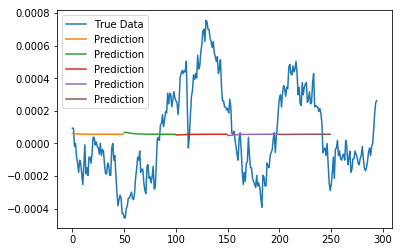

In [39]:
predictions = predict_sequences_multiple(model, X_test, 50, 50)

plot_results_multiple(predictions, y_test, 50)